In [1]:
import cx_Oracle
import os
import pandas as pd
#!pip insall cx_Oracle
import xlwings as xw
import pandas as pd
wb_cy = xw.Book('cytiva.xlsm')
SHEET_NAMES =  ['Temp_DB', 'Shipment information', '인수증', 
'대리점송장', '대리점 출고대기', '로컬리스트', 'In-Transit part report', '기타리스트',
 '출고리스트', 'Cytiva Inventory BIN']
LOCATION = r"C:\Users\lms46\Desktop\fulfill\instantclient_fulfill"
os.environ["PATH"] = LOCATION + ";" + os.environ["PATH"]
cx_Oracle.init_oracle_client(lib_dir=LOCATION)

connection = cx_Oracle.connect(
    user='dw_fulfill', password='fulfillment123QWE!@#', dsn='fulfill_high'

)
cursor = connection.cursor()

In [49]:
import datetime as dt
connection = cx_Oracle.connect(
    user='dw_fulfill', password='fulfillment123QWE!@#', dsn='fulfill_high'

)
cursor = connection.cursor()

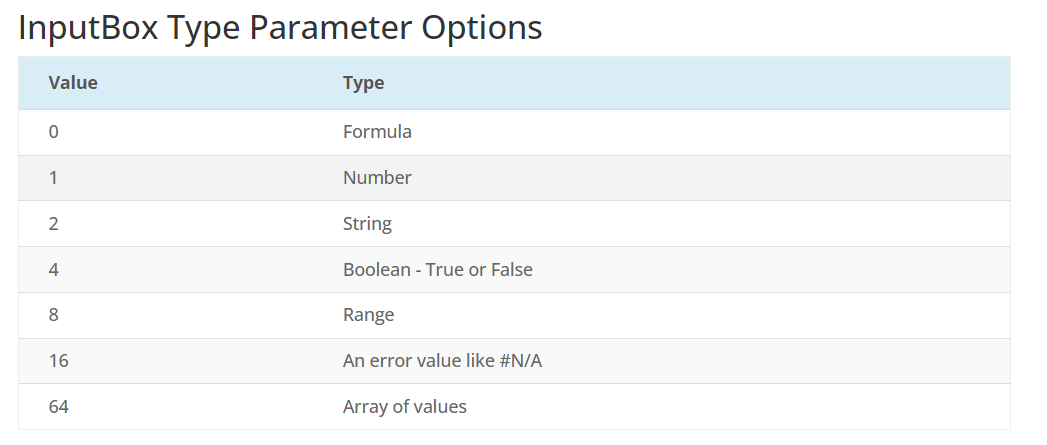

## WAREHOUSING
- 특정일 창고로 실물(시스템상)입고되는 품목들..
- WAREHOUSING_READY()로 일단 대기상태에 진입
    - 왜냐하면.. 입고 예정인 상태에서 실입고는 몇시간에서 최대 몇일 까지 걸릴 수도 있음
    - DAMAGE,WRONG,SHORT,OVER SHIP상태에서 안전한지 확인이 되지 않음 -> 검수전
    - 대리점품목
    
### WAREHOUSING_READY()
1. SHIPREADY랑 비슷한 로직
    - wating_for_out에서만 사용가능
    - ARRIVAL_DATE에 값이 있으면 사용 불가
2. 금지되는 조건에 벗어난 경우 로직시작
    - selection.visible -> win32api의 vba 보이는 셀만 선택을 사용하여 드래그 품목에서도 특히 보이는 부분만 입고진행
    1. 입고품목 드래그 후 버튼클릭.. 
    2. 입고날짜 TODAY인지 확인 받기 YES -> 4번으로고고, NO -> 입고날짜 입력받기, cancel - > return None:로직종료 
    3. 입고날짜 받기 vba inputbox type 1 number => 
        - input_month 월 입력받기
        - input_day 일 입력받기
        - 입력받는 날짜 합치기
    4. ARRIVAL_DATE에 input_date 입력 해당 행의 STATUS는 HOLDING 상태로 변경 ==> DB,XL 모두 변경
        - 향후 OUT_BOUND에서 STATUS HOLDING상태에서는 출고금지
    5. 입고 검수지 출력, WAREHOUSING_inspection() 불러오기, 대리점 입고예정.pdf 특정폴더에 생성 및 메일 작성
    
    
    
#### WAREHOUSING_inspection()
-  입고품목 검수지 출력

1. WAREHOUSING_READY()에서 입력받은 ARRIVAL_DATE사용 하여 SHIPMENT_INFORMATION DB에서 QUERY로 awb,order_nm,ship_to,parcels_no 받아오기


#### BRANCH_RECEIVING()
- 대리점 입고예정메일
    - 추후에는 WEB에서 따로 안내할 예정
- 메일을 써야함 mail주소는 DB BRANCH에서 가져올 예정
- 입고예정에 필요한 column = ARRIVAL_DATE	AWB_NO	TRIP_NO	NM_OF_PACKAGE	PARCELS_NO	ORDER_NM	SHIP_TO

- pdf로 만들어 파일도 전달
- CI파일 받기위한 리스트도 따로 만들기

In [2]:
def warehousing_inspection():
    print_form_dir = "C:\\Users\\lms46\\Desktop\\fulfill\\xlwings_job\\print_form.xlsx"
    wb_pf = xw.Book(print_form_dir)
    ws_wi = wb_pf.sheets['WAREHOUSING_INSPECTION']
    
    # 입고날짜 임시로정함
    tmp_in_date = '2022-10-06'
    input_date = tmp_in_date
    print_form_dir = "C:\\Users\\lms46\\Desktop\\fulfill\\xlwings_job\\print_form.xlsx"
    wb_pf = xw.Book(print_form_dir)
    division_list = ['대리점','SVC', 'SO','특송']
    
    # 대리점리스트 가져오기 FROM DB
    branch_list = cursor.execute('select branch_name from branch').fetchall()
    branch_list = list(map(lambda e: str(e).replace("('","").replace("',)","")
                           ,branch_list))

    # print_form에서 사용할 컬럼명
    col_list = ['AWB_NO','ORDER_NM','SHIP_TO','PARCELS_NO','CHECK','COMMENT','DIVISION']
    join_col = ', '.join(col_list[:-3]) # query용 join
    
    # DB불러오기
    df_in_1 = pd.DataFrame(
        cursor.execute(f"select {join_col} from SHIPMENT_INFORMATION where ARRIVAL_DATE = '{input_date}'").fetchall(),
        columns=col_list[:-3]
    )
    df_in_2= pd.DataFrame(columns=col_list[4:])
    df_in = pd.concat([df_in_1,df_in_2],axis=1).fillna("")
    
    # fill division col Division나누기
    for i in range(len(df_in)):
        col_divi = df_in['DIVISION']
        if 'IR' in df_in.iloc[i]['ORDER_NM'] :
            col_divi[i] = division_list[1]
        elif df_in.iloc[i]['ORDER_NM'] == '':
            col_divi[i] = division_list[3]
        elif df_in.iloc[i]['SHIP_TO'] in branch_list:
            col_divi[i] = division_list[0]
        else : 
            col_divi[i] = division_list[2]
    df_in.sort_values(['DIVISION', 'SHIP_TO'],ascending=[True,True],inplace=True)        
    df_in.set_index('DIVISION',inplace=True)
    
    # xs_wi 내용삭제 후 입고품목 입력
    last_row = ws_wi.range("A1048576").end('up').row
    if last_row == 3 :
        last_row = 4
    ws_wi.range((4,1),(last_row,"G")).clear()
    ws_wi.range("A3").value = df_in
    ws_wi.range("C2").value = str(len(df_in)) + " carton" # 화물개수
    ws_wi.range("E2").value = input_date # 입고일자
    
    
    # 서식정리
    last_row = ws_wi.range("A1048576").end('up').row
    ws_wi.range((4,1),(last_row,"G")).api.Borders.LineStyle = 1
    ws_wi.range((4,1),(last_row,"G")).api.HorizontalAlignment = xw.constants.HAlign.xlHAlignCenter
    
    # Print 개발모드에서는 PrintPreivew
    ws_wi.range((1,1),(last_row,"G")).api.PrintPreview()
    # ws_wi.range((1,1),(last_row,"G")).api.Print()

In [3]:
import win32com.client as cli
outlook = cli.Dispatch("Outlook.Application").GetNamespace("MAPI") # 아웃룩
inbox = outlook.GetDefaultFolder(6) # 받은편지함
msg = inbox.Items #메세지 정보
msg_counter = msg.count # 총갯수
msg_counter

0

In [72]:
import html
import os

def branch_receiving():
    print_form_dir = "C:\\Users\\lms46\\Desktop\\fulfill\\xlwings_job\\print_form.xlsx"
    wb_pf = xw.Book(print_form_dir)
    ws_br_in = wb_pf.sheets['BRANCH_RECEIVING']
    worker = '홍길동'
    outlook_send=cli.Dispatch("Outlook.Application")

    # DB에서 값가져오기
    tmp_in_date = '2022-10-06'
    input_date = tmp_in_date

    col_list = ['ARRIVAL_DATE', 'AWB_NO', 'TRIP_NO', 'NM_OF_PACKAGE', 'PARCELS_NO', 'ORDER_NM', 'SHIP_TO']
    join_col = ', '.join(col_list)

    branch_list = cursor.execute('select branch_name from branch').fetchall()
    branch_list = list(map(lambda e: str(e).replace("('","").replace("',)","")
                           ,branch_list))

    df_in = pd.DataFrame(
        cursor.execute(f"select {join_col} from SHIPMENT_INFORMATION where ARRIVAL_DATE = '{input_date}'").fetchall(),
        columns=col_list
    )
    df_db_br = pd.DataFrame(cursor.execute('select * from branch').fetchall())
    
    # 입고된 브랜치리스트만 추리기
    df_list = []
    for br_name in branch_list:
        df_list.append(df_in[df_in['SHIP_TO']==br_name])
    df_br = pd.concat(df_list).reset_index(drop=True).replace("None")
    in_br_list = list(df_br['SHIP_TO'].sort_values().drop_duplicates())
    
    ci_dict_list = []
    # 메일저장 및 form 제작 작업
    for br_name in in_br_list:
        
        df_tmp = df_in[df_in['SHIP_TO']==br_name].reset_index(drop=True).replace("None",pd.NA).set_index('ARRIVAL_DATE')
        to_mail = df_db_br[df_db_br[0]==br_name][2].iloc[0]
        cc_mail = df_db_br[df_db_br[0]==br_name][2].iloc[0]
        
        ### xl form 채우기###
        
        nm_pakage = df_tmp['NM_OF_PACKAGE']
        last_row =  ws_br_in.range("A1048576").end('up').row
        
        ci_list = {"branch":br_name,"ci_list":list(df_tmp['TRIP_NO'].drop_duplicates())}
        ci_dict_list.append(ci_list)
        if last_row < 9: 
            last_row = 9
        ws_br_in.range((9,1),(last_row,"G")).clear()
        ws_br_in.range("A8").value = df_tmp
        last_row =  ws_br_in.range("A1048576").end('up').row
        content = ws_br_in.range((9,1),(last_row,"G"))
        content.api.Borders.LineStyle = 1
        content.api.HorizontalAlignment = xw.constants.HAlign.xlHAlignCenter
        content.font.size = 11
        ws_br_in.range("A2").value = f'DHL {worker} 입니다.'
        ws_br_in.range("A4").value = f'{input_date[5:].replace("-","월 ")+"일"} 통관되어 {input_date[5:].replace("-","월 ")+"일"}입고 예정인 리스트 입니다.'
        ws_br_in.range("A7").value = f'총 {nm_pakage.count()} Carton 입니다.'
        ### xl form 채우기###
        
        
        # 메일 저장 작업
        file_name = 'BR_HTML_CONTENT.html'
        br_html = os.getcwd() + '\\'+file_name
        ws_br_in.to_html(file_name)
        html_body = html.unescape(open(br_html).read())
        ful_conent = ws_br_in.range((1,1),(last_row,"G"))
        mail_obj = outlook_send.CreateItem(0)
        mail_obj.To = to_mail
        mail_obj.CC = cc_mail
        mail_obj.Subject = br_name + " " + input_date + " 입고예정 품목"
        mail_obj.HTMLBody = html_body
        os.remove(br_html)
        mail_obj.Save()
        
    return ci_dict_list

In [74]:
dict_tmp = branch_receiving()

In [75]:
import json

In [77]:
json.dumps(dict_tmp,ensure_ascii=False)

'[{"branch": "닥터바이오", "ci_list": ["115356551", "115357321", "115358712", "115358237"]}, {"branch": "동일과학", "ci_list": ["115356549", "115357320", "115358711", "115358236"]}, {"branch": "바이나리", "ci_list": ["115357333", "115358716", "115358229"]}, {"branch": "바이오토프", "ci_list": ["115357326", "115358240"]}, {"branch": "비앤비대전", "ci_list": ["115356528", "115357329", "115358714", "115358241"]}, {"branch": "서린바이오사이언스", "ci_list": ["115357334", "115358717", "115358252"]}, {"branch": "이효바이오사이언스", "ci_list": ["115356529", "115357330", "115358715", "115358242"]}, {"branch": "지더블유바이텍가산", "ci_list": ["115356532", "115356526", "115358718", "115358253"]}, {"branch": "지더블유바이텍광주", "ci_list": ["115356526", "115357319", "115358710"]}]'